## Imports

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

sns.set_style("whitegrid")
sns.set_context("paper")

## Paths

In [2]:
usdcusdt_path = './data/USDC-USDT_1488326400_1573985400.csv'
btceth_path = './data/BTC-ETH_1488326400_1574949900.csv'
usdtbtc_path = './data/USDT-BTC_1488326400_1574955000.csv'
btcbchabc_path = './data/BTC-BCHABC_1488326400_1574950500.csv'

## Strategic Game

The strategic game, as shown in *Fig. 2*, is conceptualized as a *binary decision tree*, derived from HTLC protocol described in *Fig. 1*.  

In [3]:
class StrategicGame:
    
    def __init__(self, payoffs):
        self.root = None
        self.build(payoffs)
        
        
        
    def build(self, payoffs):
        '''
        Builds a binary decision tree which acts as a strategic game
        '''
        # NOTE last decision is always done by agent A
        agent = 'A'
        last_h = Node(0, None, None, agent, payoffs[-1][0], payoffs[-1][1])

        for payoff in reversed(payoffs[:-1]):
            z = Node(0, None, None, agent, payoff[0], payoff[1])
            h = Node(0, last_h, z, agent, None, None)
            last_h = h

            if agent == 'A':
                agent = 'B'
            else:
                agent = 'A'
                
        self.root = last_h
        
        
    
    def backwards_induction(self):
        '''
        Use the backwards induction algorithm to determine the nash equilibrium
        '''
        leaves = self.get_leaves()
        nash_eq_node = None

        for leaf in reversed(leaves):
            if nash_eq_node is None:
                nash_eq_node = leaf
            else:
                if leaf.agent == "A":
                    if leaf.utility_A > nash_eq_node.utility_A:
                        nash_eq_node = leaf
                else:
                    if leaf.utility_B > nash_eq_node.utility_B:
                        nash_eq_node = leaf

        return [nash_eq_node.utility_A, nash_eq_node.utility_B]
    
    
    
    def get_leaves(self):
        '''
        Get all leaves of the decision tree (the z nodes), 
        which are associated with the different utilities
        '''
        # NOTE the last two leaves are chosen by agent i
        leaves = []
        node = self.root

        # find all leaves by traversing h_nodes
        while True:
            if node.node_z:
                leaves.append(node.node_z)
                node = node.node_h
            else:
                leaves.append(node)
                break
    
        return leaves



class Node:
    
    def __init__(self, timepoint_t, node_h, node_z, agent, utility_A, utility_B):
        self.timepoint_t = timepoint_t
        self.node_h = node_h
        self.node_z = node_z
        self.agent = agent
        self.utility_A = utility_A
        self.utility_B = utility_B
        

##### Examples

In [6]:
# example: solution should be [20, 0] (chosen by i)
utility = [[0, 0], [-1, 0], [-1, -1], [20, 0]]

tree = StrategicGame(utility)
result = tree.backwards_induction()

print("Nash Equilibrium = " + str(result[0]) + ", " + str(result[1]))

Nash Equilibrium = 20, 0


In [7]:
# example: solution should be [6, 11| (chosen by j)
utility = [[0, 0], [-1, 0], [-1, -1], [6, 11], [7, 10], [5, 0]]

tree = StrategicGame(utility)
result = tree.backwards_induction()

print("Nash Equilibrium = " + str(result[0]) + ", " + str(result[1]))

Nash Equilibrium = 6, 11


## Geometric Brownian Motion

This class implements a random geometric Brownian motion. For a specific motion, please use the `seed` variable.

In [8]:
class GeometricBrownianMotion():
    
    def __init__(self, x_0, mu, sigma, t_final, seed, gamma, confidence=1.96):
        # curve attributes
        self.x_0 = x_0
        self.mu = mu
        self.sigma = sigma
        self.t_final = t_final
        self.seed = seed
        self.gamma = gamma
        self.confidence = confidence
        
        # calculations
        self.t_i = self.t_i()
        self.trajectory = self.simulate()
        self.expected_trajectory = self.expected_trajectory()
        conf_pos, conf_neg = self.confidence_interval()
        self.confidence_interval_positive = conf_pos
        self.confidence_interval_negative = conf_neg
        self.decision_point_data = self.decision_point_data()
        
    
    
    def t_i(self):
        '''
        Create timeline array
        '''
        t_i = np.linspace(0, self.t_final, self.t_final+1)
        return t_i
        
    
    
    def simulate(self):
        np.random.seed(self.seed)

        # create Wiener-process
        W_t = np.cumsum(np.random.standard_normal(size=self.t_final+1))*np.sqrt(1)

        # create exchange-rate
        x_n = np.array([self.x_0])

        for t in range(self.t_final+1):
            if t != 0:
                x_i = self.x_0 * np.exp(((self.mu-(self.sigma**2/2))*t) + self.sigma*W_t[t])
                x_n = np.append(x_n, x_i)

        return x_n



    def expected_value(self, x_i, t):
        '''
        Returns the expected value from a timepoint t
        '''
        return x_i * math.exp(self.mu*t)

    

    def expected_trajectory(self):
        '''
        Calculates the expected trajectory of a gbm
        '''
        exp_val = [self.x_0]
        for t in range(1, self.t_final+1):
            exp = self.expected_value(self.x_0, t)
            exp_val.append(exp)

        return exp_val
    
    
    
    def decision_point_data(self):
        '''
        Return the values for all points which involve a decision from one party
        '''
        decision_point_data = []
        diff = int(self.t_final / 4)
        for t in range(0, self.t_final+1, diff):
            expected = self.expected_value(self.trajectory[t], self.t_final-t)
            decision_point_data.append([t, self.trajectory[t], expected])
        
        return decision_point_data

        
    
    
    def confidence_interval(self):
        '''
        Calculates the conficence interval for a gbm
        '''
        conf_pos = []
        conf_neg = []

        for t in range(self.t_final+1):
            var = ((self.expected_trajectory[t]**2) * math.exp(2*self.mu*t)) * (math.exp((self.sigma**2)*t)-1)
            conf_pos.append(self.expected_trajectory[t]+math.sqrt(var)*self.confidence)
            conf_neg.append(self.expected_trajectory[t]+math.sqrt(var)*-self.confidence)

        return conf_pos, conf_neg
        
        
        
    def draw(self):
        '''
        Draws a geometric Brownian motion
        '''
        # caps
        gamma_pos = np.full(self.t_i.shape, self.x_0+self.gamma)
        gamma_neg = np.full(self.t_i.shape, self.x_0-self.gamma)
        
        # opposite curve
        opposite = 1 / self.trajectory

        # aggregation
        data = {'t_i': self.t_i, 'gbm': self.trajectory, 'opposite': opposite, 'exp_val': self.expected_trajectory, 'conf_pos': self.confidence_interval_positive, 'conf_neg': self.confidence_interval_negative, 'gamma_pos': gamma_pos, 'gamma_neg': gamma_neg}
        columns = ['t_i', 'gbm', 'opposite', 'exp_val', 'gamma_pos', 'gamma_neg', 'conf_pos', 'conf_neg']
        ds = pd.DataFrame(data, columns=columns)

        # plotting
        ax = sns.lineplot(data=ds['exp_val'], color="darksalmon", label=r'$Expected \;Values$')
        ax = sns.lineplot(data=ds['gamma_pos'], color="firebrick", label=r'$\mathrm{\gamma = +' + str(self.gamma) + '}$')
        ax = sns.lineplot(data=ds['gamma_neg'], color="firebrick", label=r'$\mathrm{\gamma = -' + str(self.gamma) + '}$')
        ax = sns.lineplot(data=ds['conf_pos'], color="palevioletred", label=r'$\mathrm{Z = +' + str(self.confidence) + '}$')
        ax = sns.lineplot(data=ds['conf_neg'], color="palevioletred", label=r'$\mathrm{Z = -' + str(self.confidence) + '}$')
        ax = sns.lineplot(data=ds['opposite'], color="silver", label=r'$1\;/\;GBM$')
        ax = sns.lineplot(data=ds['gbm'], color="navy", label=r'$GBM$')
        ax.lines[0].set_linestyle("--")
        ax.lines[1].set_linestyle("--")
        ax.lines[2].set_linestyle("--")
        ax.lines[3].set_linestyle("--")
        ax.lines[4].set_linestyle("--")
        ax.lines[5].set_linestyle("-")

        leg = ax.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        counter = 0
        for point in self.decision_point_data:
            # horizontal & vertical
            if counter == 0 or counter == 4:
                plt.plot([point[0], self.t_final], [point[1], point[2]], color="silver", linestyle="--")
                plt.axvline(x=point[0], ymin=0.1, ymax=0.9, color="silver", linestyle=":")
            else:
                plt.plot([point[0], self.t_final], [point[1], point[2]], color="royalblue", linestyle="--")
                plt.axvline(x=point[0], ymin=0.1, ymax=0.9, color="darksalmon", linestyle=":")
                
            plt.text(point[0], self.confidence_interval_negative[-1], r'$t_' + str(counter) + '$')
            counter += 1
            
        # plt.savefig(fname=<path>, quality=95, dpi=150, bbox_extra_artists=(leg,), bbox_inches='tight')
        

##### Examples

[[0, 1.0, 1.0], [12, 0.9855513587200837, 0.9855513587200837], [24, 1.009818800529519, 1.009818800529519], [36, 0.9995103062684163, 0.9995103062684163], [48, 0.9880246254905121, 0.9880246254905121]]


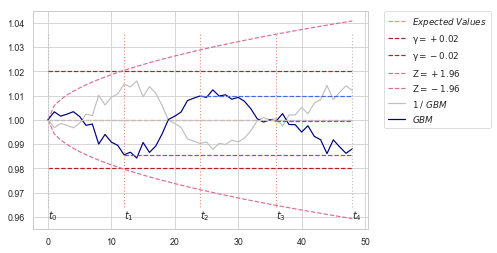

In [9]:
gbm_success = GeometricBrownianMotion(1.0, 0.0, 0.003, 48, 35435, 0.02)
gbm_success.draw()

print(gbm_success.decision_point_data)

[[0, 1.0, 1.0], [6, 0.9976998792502242, 0.9976998792502242], [12, 0.9855513587200837, 0.9855513587200837], [18, 0.9941748335667935, 0.9941748335667935], [24, 1.009818800529519, 1.009818800529519]]


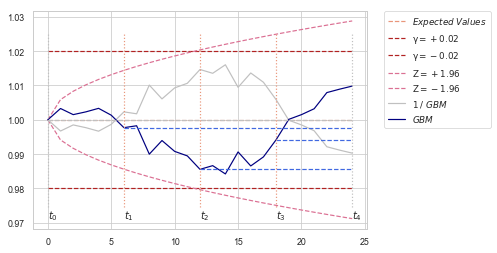

In [10]:
gbm_success = GeometricBrownianMotion(1.0, 0.0, 0.003, 24, 35435, 0.02)
gbm_success.draw()

print(gbm_success.decision_point_data)

[[0, 1.0, 1.009646227810575], [12, 1.0003567842486891, 1.007585344685498], [24, 0.9942577087168922, 0.9990416179157083], [36, 0.9697745295869757, 0.9721047836443314], [48, 0.9538589535782374, 0.9538589535782374]]


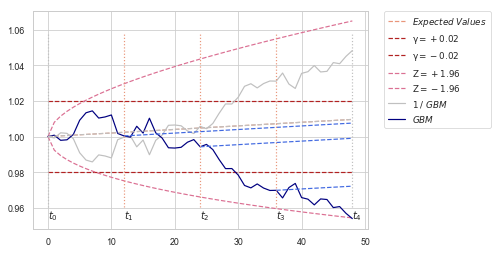

In [11]:
gbm_failure = GeometricBrownianMotion(1.0, 0.0002, 0.004, 48, 5251123, 0.02)
gbm_failure.draw()

print(gbm_failure.decision_point_data)

## Game Solver

This class is used for finding the **Nash equilibrium** by using the *backwards induction* algorithm.

The *strategic game* and the *utility function* are therefore combined to determine the *payoffs* over a game.

In [14]:
class GameSolver():
    
    def __init__(self, gamma, eta, quantity, gbm):
        self.gamma = gamma
        self.eta = eta
        self.quantity = quantity
        self.gbm = gbm
        self.payoffs = self.payoffs()
        self.success = self.evaluate_series()
        self.failed_at = None
        self.correct_initial_estimation = self.correct_initial_estimation()
        self.classification = self.classification()
        
        
    def chi_0(self, t_x):
        '''
        Represents the step function chi_0
        '''
        if t_x >= 4:
            raise Exception('t_x should not exceed 4 (max value of t_final). The value of t_x was: {}'.format(t_x))
        elif t_x < 0:
            raise Exception('t_x should not be negative. The value of t_x was: {}'.format(t_x))
        elif t_x == 3:
            return 1, 1
        else: 
            return 0, 0
    
    
    
    def chi_1(self, t_x):
        '''
        Represents the step function chi_1
        '''
        if t_x >= 4:
            raise Exception('t_x should not exceed 4 (max value of t_final). The value of t_x was: {}'.format(t_x))
        elif t_x < 0:
            raise Exception('t_x should not be negative. The value of t_x was: {}'.format(t_x))
        elif t_x == 3:
            return 2, 2
        elif t_x == 2:
            return 1, 1
        elif t_x == 1:
            return 1, 0
        elif t_x == 0:
            return 0, 0
        
        
        
    def payoffs(self):
        '''
        Calculates the payoffs for both agents, for each stage of the game
        based on the current price point at time t
        '''
        timeline = []
        counter = 0
        
        # exclude first and last one
        for point in self.gbm.decision_point_data[1:-1]:
            est_x_final_i = point[2]
            est_x_final_j = 1 / est_x_final_i

            payoffs = []
            
            for t in range(counter, 4):
                chi_0_i, chi_0_j = self.chi_0(t)
                chi_1_i, chi_1_j = self.chi_1(t)
                
                u_i = chi_0_i * ((est_x_final_i - self.gbm.x_0) * self.quantity + (self.gbm.x_0 * self.gamma) * self.quantity) - (chi_1_i * self.eta)
                u_j = chi_0_j * ((self.gbm.x_0 - est_x_final_i) * self.quantity + (self.gbm.x_0 * self.gamma) * self.quantity) - (chi_1_j * self.eta)
                
                payoffs.append([u_i, u_j])
            
            timeline.append(payoffs)
            counter += 1
    
        return timeline
    
    
    
    def evaluate_game(self, t):
        '''
        Evaluated if a trade would be a success
        '''
        strategic_game = StrategicGame(self.payoffs[t])
        nash_eq = strategic_game.backwards_induction()
        
        # if successfull
        if nash_eq == self.payoffs[t][-1]:
            return True
        else:
            return False
        
    
    
    def evaluate_series(self):
        # last two payoffs are both decided by same agent i
        for t in range(len(self.payoffs)):
            success = self.evaluate_game(t)
            if not success:
                self.failed_at = 't_' + str(t)
                return False
        
        return True

    
    
    def correct_initial_estimation(self):
        start = self.gbm.decision_point_data[0][1]
        exp = self.gbm.decision_point_data[0][-1]
        end = self.gbm.decision_point_data[-1][-1]
        difference_actual = (end / start) - 1
        difference_estimated = (exp / start) - 1
        
        
        if (difference_actual <= self.gamma) and (difference_actual >= -self.gamma):
            success_actual = True
        else:
            success_actual = False

        if (difference_estimated <= self.gamma) and (difference_estimated >= -self.gamma):
            success_estimated = True
        else:
            success_estimated = False
            
        if (success_actual and success_estimated) or (not success_actual and not success_estimated):
            return True
        else:
            return False
        
        
    def classification(self):
        start = self.gbm.decision_point_data[0][1]
        exp = self.gbm.decision_point_data[0][-1]
        end = self.gbm.decision_point_data[-1][-1]
        difference_actual = (end / start) - 1
        difference_estimated = (exp / start) - 1
        
        if (difference_actual <= self.gamma) and (difference_actual >= -self.gamma):
            success_actual = True
        else:
            success_actual = False

        if (difference_estimated <= self.gamma) and (difference_estimated >= -self.gamma):
            success_estimated = True
        else:
            success_estimated = False
            
        if (success_actual and success_estimated):
            return "TP"
        
        if (not success_actual) and (not success_estimated):
            return "TN"
        
        if success_actual and (not success_estimated):
            return "FN"
        
        if (not success_actual) and success_estimated:
            return "FP"            
                          

##### Examples

Success: True
Correct Estimation: True
Classification: TP


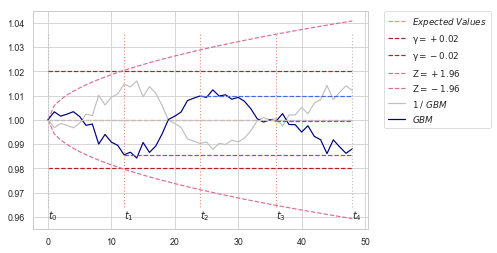

In [15]:
gbm_success = GeometricBrownianMotion(1.0, 0.0, 0.003, 48, 35435, 0.02)
gbm_success.draw()
solver = GameSolver(0.02, 0, 1, gbm_success)
print('Success: ' + str(solver.success))
print('Correct Estimation: ' + str(solver.correct_initial_estimation))
print('Classification: ' + solver.classification)

Success: False
Correct Estimation: False
Classification: FP


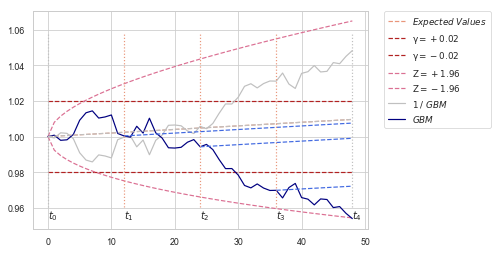

In [16]:
gbm_failure = GeometricBrownianMotion(1.0, 0.0002, 0.004, 48, 5251123, 0.02)
gbm_failure.draw()
solver = GameSolver(0.02, 0, 1, gbm_failure)
print('Success: ' + str(solver.success))
print('Correct Estimation: ' + str(solver.correct_initial_estimation))
print('Classification: ' + solver.classification)

## Test Series

Creates and tests a series of geometric Brownian motions.

In [38]:
class TestSeries():
    
    def __init__(self, n, gamma, eta, quantity, x_0, mu, sigma, t_final, confidence):
        # test related
        self.n = n
        
        # strategic game related
        self.gamma = gamma
        self.eta = eta
        self.quantity = quantity
        
        # geometric brownian motion related
        self.x_0 = x_0
        self.mu = mu
        self.sigma = sigma
        self.t_final = t_final
        self.confidence = confidence
        
        # results
        self.success = []
        self.failed = []
        self.correct_estimation_rate = 0.0
        self.success_rate = self.execute()
        
    
    def execute(self):
        correct_estimation = 0
        for i in range(self.n):
            gbm = GeometricBrownianMotion(self.x_0, self.mu, self.sigma, self.t_final, None, self.gamma, self.confidence)
            solver = GameSolver(self.gamma, self.eta, self.quantity, gbm)
            
            if solver.success:
                self.success.append(solver)
            else:
                self.failed.append(solver)
            
            if solver.correct_initial_estimation:
                correct_estimation = correct_estimation + 1
        
        self.correct_estimation_rate = correct_estimation / self.n
        success_rate = len(self.success) / self.n
        return success_rate
            

##### Examples

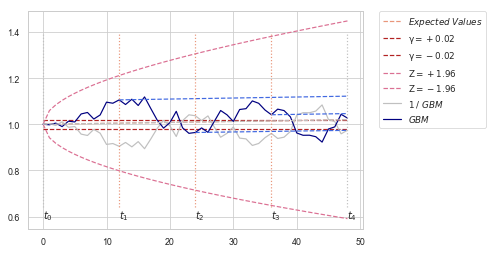

In [17]:
n = 100
gamma = 0.02 
eta = 0
quantity = 1
x_0 = 1.0
mu = 0.0004
sigma = 0.03
t_final = 48
confidence = 1.96

test = TestSeries(n, gamma, eta, quantity, x_0, mu, sigma, t_final, confidence)
test.failed[0].gbm.draw()

## Rational Verification

This class is used to conduct the verification on the introduced model of rationality itself, see *Fig. 4*.

In [39]:
class RationalVerification():
    
    def __init__(self, n_per_series, range_gamma, eta, quantity, x_0, range_mu, range_sigma, t_final, confidence):
        self.n_per_series = n_per_series
        self.range_gamma = range_gamma
        self.eta = eta
        self.quantity = quantity
        self.x_0 = x_0
        self.range_mu = range_mu
        self.range_sigma = range_sigma
        self.t_final = t_final
        self.confidence = confidence
        
        self.execute()
        
        
    def execute(self):
        
        fig, axs = plt.subplots(1, 4)
        fig.set_figwidth(20)
        
        # sigma plotting
        for gamma in self.range_gamma:
            
            success_rates = []
            correct_estimation_rates = []
            
            for sigma in self.range_sigma:
                test = TestSeries(self.n_per_series, gamma, self.eta, self.quantity, self.x_0, 0, sigma, self.t_final, self.confidence)
                success_rates.append(test.success_rate)
                correct_estimation_rates.append(test.correct_estimation_rate)
            print("Volatility " + str(gamma))
            print(success_rates)
            data = {'sigmas': self.range_sigma, 'success': success_rates}
            columns = ['sigmas', 'success']
            ds = pd.DataFrame(data, columns=columns)
            ax = sns.lineplot(x="sigmas", y="success", data=ds, palette=sns.color_palette('GnBu_d'), label=r'$\gamma =\;' + str(round(gamma, 3)) + '$', ax=axs[1])
            
            print("Estimations " + str(gamma))
            print(correct_estimation_rates)
            data = {'sigmas': self.range_sigma, 'correct_estimations': correct_estimation_rates}
            columns = ['sigmas', 'correct_estimations']
            ds = pd.DataFrame(data, columns=columns)
            ax = sns.lineplot(x="sigmas", y="correct_estimations", data=ds, palette=sns.color_palette('GnBu_d'), label=r'$\gamma =\;' + str(round(gamma, 3)) + '$', ax=axs[3])
            
        axs[1].set_xlabel(r'$Volatility \;\sigma$')
        axs[1].set_ylabel(r'$Success-Rate \;in \;\%$')
        
        axs[3].set_xlabel(r'$Volatility \;\sigma$')
        axs[3].set_ylabel(r'$Correct \;Initial \;Estimations \;in \;\%$')
        
        
        # time plotting
        range_time = [4, 8, 12, 24, 36, 48]
        for t_final in range_time:
            gamma = 0.02
        
            success_rates = []
            correct_estimation_rates = []
            
            for sigma in self.range_sigma:
                test = TestSeries(self.n_per_series, gamma, self.eta, self.quantity, self.x_0, 0, sigma, t_final, self.confidence)
                success_rates.append(test.success_rate)
            
            print('Time ' + str(t_final))
            print(success_rates)
            data = {'sigmas': self.range_sigma, 'success': success_rates}
            columns = ['sigmas', 'success']
            ds = pd.DataFrame(data, columns=columns)
            ax = sns.lineplot(x="sigmas", y="success", data=ds, palette=sns.color_palette('GnBu_d'), label=r'$T =\; ' + str(t_final) + 'H$', ax=axs[2])
            
        axs[2].set_xlabel(r'$Volatility \;\sigma$')
        axs[2].set_ylabel(r'$Success-Rate \;in \;\%$')
        
        
        # mu plotting
        for gamma in self.range_gamma:
            success_rates = []
            for mu in self.range_mu:
                test = TestSeries(1, gamma, self.eta, self.quantity, self.x_0, mu, 0, self.t_final, self.confidence)
                success_rates.append(test.success_rate)
            
            print('Drift ' + str(gamma))
            print(success_rates)
            data = {'mu': self.range_mu, 'success': success_rates}
            columns = ['mu', 'success']
            ds = pd.DataFrame(data, columns=columns)

            # plotting
            ax = sns.lineplot(x="mu", y="success", data=ds, palette=sns.color_palette('GnBu_d'), label=r'$\gamma =\;' + str(round(gamma, 3)) + '$', ax=axs[0])
       
        axs[0].set_xlabel(r'$Drift \;\mu$')
        axs[0].set_ylabel(r'$Success-Rate \;in \;\%$')
        plt.savefig(fname='/Users/janickrueegger/anaconda3/notebooks/rationalverification/figures/rv_gbm.jpg', quality=95, dpi=150, bbox_inches='tight', pad_inches=0)
        plt.show(block=True)
        

##### Examples

Please note that the results might differ between runs and hence most probably do not excatly represent the result of the paper. 

The generation of *geometric Brownian motions* is randomized based on a changing distribution of the Wiener process $W_t$.

Volatility 0.01
[0.929, 0.534, 0.326, 0.189, 0.132, 0.085, 0.06, 0.057, 0.054, 0.029, 0.027, 0.025, 0.005, 0.022, 0.009]
Estimations 0.01
[0.873, 0.526, 0.348, 0.25, 0.218, 0.195, 0.17, 0.166, 0.117, 0.101, 0.103, 0.093, 0.104, 0.084, 0.084]
Volatility 0.015
[0.992, 0.786, 0.533, 0.365, 0.277, 0.17, 0.14, 0.104, 0.075, 0.064, 0.073, 0.049, 0.041, 0.036, 0.023]
Estimations 0.015
[0.967, 0.71, 0.524, 0.399, 0.35, 0.288, 0.229, 0.217, 0.186, 0.16, 0.153, 0.145, 0.123, 0.125, 0.125]
Volatility 0.019999999999999997
[1.0, 0.92, 0.731, 0.561, 0.399, 0.292, 0.252, 0.172, 0.146, 0.114, 0.098, 0.08, 0.07, 0.069, 0.057]
Estimations 0.019999999999999997
[0.994, 0.83, 0.651, 0.516, 0.44, 0.36, 0.326, 0.268, 0.263, 0.227, 0.198, 0.181, 0.168, 0.149, 0.154]
Volatility 0.024999999999999998
[1.0, 0.979, 0.877, 0.705, 0.539, 0.435, 0.326, 0.307, 0.21, 0.193, 0.15, 0.136, 0.112, 0.089, 0.083]
Estimations 0.024999999999999998
[1.0, 0.933, 0.786, 0.65, 0.538, 0.464, 0.387, 0.329, 0.302, 0.282, 0.27, 0.221,

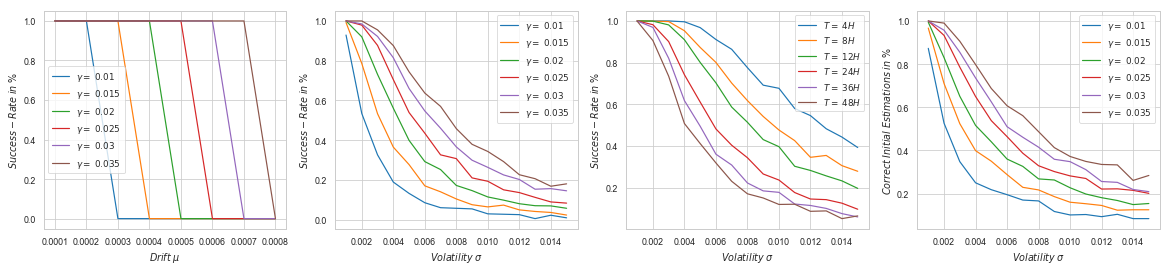

In [20]:
n = 1000
gamma_range = np.arange(0.01, 0.04, 0.005)
eta = 0
quantity = 1
x_0 = 1.0
mu_range = np.arange(0.0001, 0.0009, 0.0001)
sigma_range = np.arange(0.001, 0.016, 0.001)
t_final = 48
confidence = 1.96

rv = RationalVerification(n, gamma_range, eta, quantity, x_0, mu_range, sigma_range, t_final, confidence)

In [40]:
class HistoricPriceCurve():
    
    def __init__(self, curve, pre, gamma):
        # curve attributes
        self.curve = curve
        self.pre = pre
        self.t_final = self.curve.size-1
        self.x_0 = curve[0]
        self.mu = self.drift()
        self.sigma = self.volatility()
        self.gamma = gamma
        
        # calculations
        self.t_i = self.t_i()
        self.expected_trajectory = self.expected_trajectory()
        self.decision_point_data = self.decision_point_data()
    
    
    def decision_point_data(self):
        decision_points = []
        for t in np.arange(0, self.curve.size + 1, (self.curve.size-1) / 4):
            t = int(t)
            exp = self.expected_value(self.curve[t], (self.curve.size-1) - t)
            decision_points.append([t, self.curve[t], exp])
        return decision_points
        
    
    def drift(self):
        drift = self.pre[-1] - self.pre[0]
        percentage = drift / self.pre[0]
        percentage_t = percentage / self.pre.size
        return percentage_t
    


    def volatility(self):
        mean = self.pre_arithmetic_mean()
        difference = np.power(mean - self.pre, 2)
        variance = np.sum(difference) * (1 / (self.pre.size-1))
        volatility = math.sqrt(variance)
        percentage_t = volatility * math.sqrt(self.pre.size)
        return percentage_t
    
    
    def pre_arithmetic_mean(self):
        sum = np.sum(self.pre)
        mean = sum / self.pre.size
        return mean
    
    
    def t_i(self):
        '''
        Create timeline array
        '''
        t_i = np.linspace(0, self.t_final, self.t_final+1)
        return t_i


    def expected_value(self, x_i, t):
        '''
        Returns the expected value from a timepoint t
        '''
        return x_i * math.exp(self.mu*t)
    
    
    def expected_trajectory(self):
        '''
        Calculates the expected trajectory of a gbm
        '''
        exp_val = [self.x_0]
        for t in range(1, self.t_final+1):
            exp = self.expected_value(self.x_0, t)
            exp_val.append(exp)

        return exp_val
    
    
    def draw(self):
        '''
        Draws a geometric Brownian motion
        '''
        # caps
        pos = self.x_0 + (self.x_0*self.gamma)
        neg = self.x_0 - (self.x_0*self.gamma)
        gamma_pos = np.full(self.t_i.shape, pos)
        gamma_neg = np.full(self.t_i.shape, neg)
        
        # opposite curve
        opposite = 1 / self.curve

        # aggregation
        data = {'t_i': self.t_i, 'curve': self.curve, 'opposite': opposite, 'exp_val': self.expected_trajectory, 'gamma_pos': gamma_pos, 'gamma_neg': gamma_neg}
        columns = ['t_i', 'curve', 'opposite', 'exp_val', 'gamma_pos', 'gamma_neg']
        ds = pd.DataFrame(data, columns=columns)

        # plotting
        ax = sns.lineplot(data=ds['exp_val'], color="darksalmon", label=r'$Expected \;Values$')
        ax = sns.lineplot(data=ds['gamma_pos'], color="firebrick", label=r'$\mathrm{\gamma = +' + str(self.gamma) + '}$')
        ax = sns.lineplot(data=ds['gamma_neg'], color="firebrick", label=r'$\mathrm{\gamma = -' + str(self.gamma) + '}$')
        ax = sns.lineplot(data=ds['curve'], color="navy", label=r'$GBM$')
        ax.lines[0].set_linestyle("--")
        ax.lines[1].set_linestyle("--")
        ax.lines[2].set_linestyle("--")
        ax.lines[3].set_linestyle("-")

        leg = ax.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        counter = 0
        for point in self.decision_point_data:
            
            # horizontal & vertical
            if counter == 0 or counter == 4:
                plt.plot([point[0], self.t_final], [point[1], point[2]], color="silver", linestyle="--")
                plt.axvline(x=point[0], ymin=0.1, ymax=0.9, color="silver", linestyle=":")
            else:
                plt.plot([point[0], self.t_final], [point[1], point[2]], color="royalblue", linestyle="--")
                plt.axvline(x=point[0], ymin=0.1, ymax=0.9, color="darksalmon", linestyle=":")

            counter += 1
            
        # plt.show(block=True)
            
        # plt.savefig(fname=<path>, quality=95, dpi=150, bbox_extra_artists=(leg,), bbox_inches='tight')

In [41]:
class RationalVerificationHistoricSeries():
    
    def __init__(self, gamma_range, gamma_print, eta, quantity, start, end, file_paths, cp_names, duration_range, step):
        
        # strategic game related
        self.gamma_range = gamma_range
        self.gamma_print = gamma_print
        self.eta = eta
        self.quantity = quantity
        self.start = start
        self.end = end
        self.file_paths = file_paths
        self.cp_names = cp_names
        self.duration_range = duration_range
        self.step = step
        
        self.success_rates = []
        self.execute()
    
    
    def execute(self):
        fig = plt.figure()
        
        axes_counter = 1
        axs_counter_y = 0
        axs_counter_x = 0
        
        fig, axs = plt.subplots(len(file_paths), len(self.gamma_print))
        axs = axs.flatten()
        
        fig.set_figwidth(20)
        fig.set_figheight(13)
        
        # for each cy-pair
        for (index_file, file_path) in enumerate(self.file_paths):
            
            df = pd.read_csv(file_path)
            
            # for each duration
            for (index_duration, duration) in enumerate(self.duration_range):
                
                begin = self.start + duration
                success_rates_cp = []
                
                # for each gamma
                for gamma in self.gamma_range:
                    current = begin

                    success = []
                    failed = []
                    success_sequences = []
                    failed_sequences = []
                    
                    while current < end:

                        curve = df['close'][df['time'].between(current, current+duration)].to_numpy()
                        pre = df['close'][df['time'].between(self.start, current)].to_numpy()

                        hcp = HistoricPriceCurve(curve, pre, gamma)

                        solver = GameSolver(gamma, self.eta, self.quantity, hcp)
                        if solver.success:
                            success.append(solver)
                            success_sequences.append([current, current+duration-1])
                        else:
                            failed.append(solver)
                            failed_sequences.append([current, current+duration-1])     

                        current = current + self.step

                    total = len(success)+len(failed)
                    ratio = len(success)/total*100

                    success_rates_cp.append(ratio)

                    # if last duration
                    if (index_duration == (len(self.duration_range)-1)):

                        if (gamma in self.gamma_print):

                            t_i = df['time'][df['time'].between(begin, self.end+duration)].to_numpy()
                            curve_total = df['close'][df['time'].between(begin, self.end+duration)].to_numpy()
                            data = {'curve': curve_total, 't_i': t_i}
                            columns = ['curve', 't_i']
                            ds = pd.DataFrame(data, columns=columns)
                            ax = sns.lineplot(x="t_i", y="curve", data=ds, color="navy", label='Curve', ax=axs[axs_counter_x])

                            for sequence in success_sequences:
                                ax.axvspan(sequence[0], sequence[1], facecolor='aquamarine', alpha=0.3)
                            for sequence in failed_sequences:
                                ax.axvspan(sequence[0], sequence[1], facecolor='coral', alpha=0.3)
                                
                            ax.get_legend().remove()
                            ax.xaxis.set_label_text("")
                            ax.yaxis.set_label_text("")
                            
                            if axs_counter_y is 0:
                                ax.set_title(r'$\gamma \;=\;' + str(gamma) + '$')

                            if axs_counter_x % len(self.gamma_print) is 0:
                                ax.set_ylabel(r'$' + self.cp_names[axs_counter_y] + ' \;(48H)$')

                            if axs_counter_y is len(self.cp_names)-1:
                                ax.set_xlabel(r'$Time \;t \;(Unix)$')
                                
                            axs_counter_x = axs_counter_x + 1
                            
                self.success_rates.append(success_rates_cp)

            axs_counter_y = axs_counter_y + 1

        # plt.savefig(fname=<path>, quality=95, dpi=150, bbox_inches='tight', pad_inches=0)
        
        plt.show(block=True)
        
        fig, axs = plt.subplots(1, len(self.duration_range))
        axs = axs.flatten()
        
        fig.set_figwidth(8)
        fig.set_figheight(3)
        
        cy_pair_counter = 0
        for index, success_rate in enumerate(self.success_rates):
            print("success_rate")
            print(success_rate)
            data = {'gamma': self.gamma_range, 'success': success_rate}
            columns = ['gamma', 'success']
            ds = pd.DataFrame(data, columns=columns)
            
            duration_string = str(int((self.duration_range[index%len(self.duration_range)])/(60*60)))
            ax = sns.lineplot(x="gamma", y="success", data=ds, palette=sns.color_palette('RdBu'), label=r'$' + self.cp_names[cy_pair_counter] + ' \;('+ duration_string + 'H)$', marker="o", ax=axs[index%len(self.duration_range)])
            if (index%len(self.duration_range)) == len(self.duration_range)-1:
                cy_pair_counter = cy_pair_counter+1
        
        for index, _ in enumerate(self.duration_range):
            axs[index].set_ylim(bottom=0)
            axs[index].xaxis.set_label_text("")
            axs[index].yaxis.set_label_text("")    
            axs[index].xaxis.set_label_text(r'$Loss-Tolerance \; \gamma \;in \;\%$')
            if index == 0:
                axs[index].yaxis.set_label_text(r'$Success-Rate \;in \;\%$')

        # plt.savefig(fname=<path>, quality=95, dpi=150, bbox_inches='tight', pad_inches=0)
        
        plt.show(block=True)
        

<Figure size 432x288 with 0 Axes>

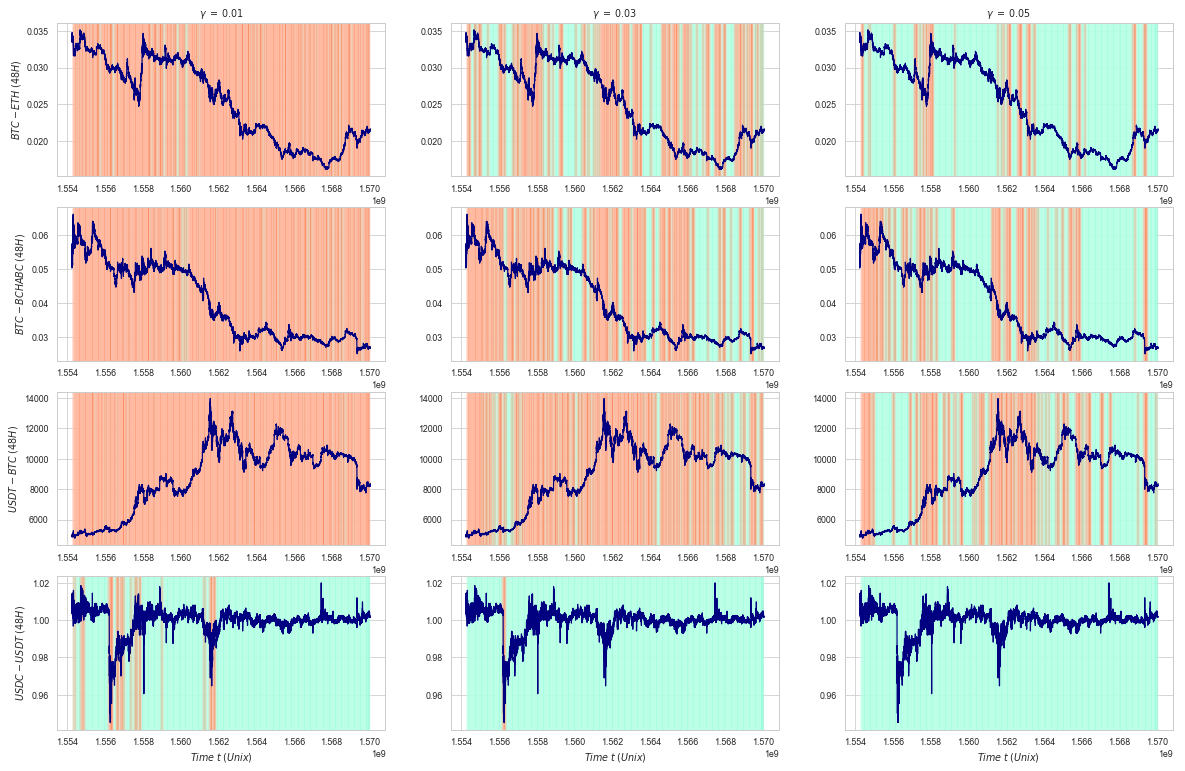

success_rate
[66.05839416058394, 79.01459854014598, 87.77372262773723, 96.53284671532847, 98.90510948905109, 100.0]
success_rate
[16.022099447513813, 30.755064456721914, 43.0939226519337, 64.64088397790056, 88.95027624309392, 97.60589318600368]
success_rate
[50.72992700729927, 69.16058394160584, 81.38686131386861, 91.24087591240875, 96.71532846715328, 98.35766423357664]
success_rate
[13.075506445672191, 23.388581952117864, 35.35911602209944, 53.03867403314917, 76.97974217311234, 90.60773480662984]
success_rate
[50.912408759124084, 68.06569343065694, 77.55474452554745, 86.67883211678831, 97.26277372262774, 99.27007299270073]
success_rate
[5.3406998158379375, 12.338858195211786, 21.178637200736645, 41.25230202578269, 68.87661141804789, 87.47697974217311]
success_rate
[99.08759124087592, 99.81751824817519, 99.81751824817519, 100.0, 100.0, 100.0]
success_rate
[94.10681399631676, 98.34254143646409, 99.0791896869245, 99.2633517495396, 100.0, 100.0]


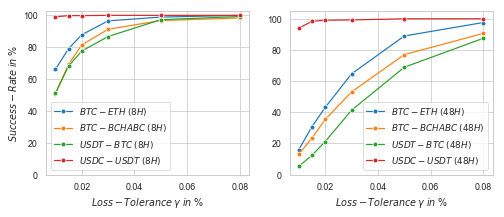

In [42]:
gamma_range = [0.01, 0.015, 0.02, 0.03, 0.05, 0.08]
gamma_print = [0.01, 0.03, 0.05]
eta = 0
quantity = 1
start = 1554076800 # 1.4.2019
end = 1569888000 # 1.10.2019
duration_range = [8*60*60, 48*60*60]
step = 8*60*60

file_paths = [btceth_path, btcbchabc_path, usdtbtc_path, usdcusdt_path]
cp_names = ['BTC-ETH', 'BTC-BCHABC', 'USDT-BTC', 'USDC-USDT']
rvhs = RationalVerificationHistoricSeries(gamma_range, gamma_print, eta, quantity, start, end, file_paths, cp_names, duration_range, step)
